In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
# setting the GPU device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

Architecture of Baseline Model:

1. Layer 1: Linear layer- Input: 46, Output: 16
2. Activation Function: ReLU
3. Layer 2: Linear layer- Input: 16, Output: 4
4. Activation Function: ReLU
5. Layer 3: Linear layer- Input: 4, Output: 1

* Loss Function: MSELoss
* Optimizer: SGD Optimizer
* Learning Rate: 1e-5
* Epochs: 50
* Batch Size: 256

In [30]:
# column details - 


# FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,ARR_DELAY,DEP_DELAY,CANCELLED,DISTANCE
# FL_DATE -- flight date (yyyy-mm-dd)
# OP_CARRIER -- carrier code
# OP_CARRIER_FL_NUM -- flight number
# ORIGIN -- origin place 
# DEST -- destination place
# CRS_DEP_TIME -- scheduled departure time (hhmm)
# DEP_TIME -- actual departure time (hhmm)
# DEP_DELAY -- departure delay (minutes)
# TAXI_OUT -- taxi out time (minutes)
# WHEELS_OFF -- wheels off time (hhmm)
# WHEELS_ON -- wheels on time (hhmm)
# TAXI_IN -- taxi in time (minutes)
# CRS_ARR_TIME -- scheduled arrival time (hhmm)
# ARR_TIME -- actual arrival time (hhmm)
# ARR_DELAY -- arrival delay (minutes)
# CANCELLED -- was the flight cancelled?
# CANCELLATION_CODE 
# DIVERTED -- was the flight diverted? (1 = yes, 0 = no)
# CRS_ELAPSED_TIME -- scheduled elapsed time (minutes)
# ACTUAL_ELAPSED_TIME -- actual elapsed time (minutes)
# AIR_TIME -- air time (minutes)
# DISTANCE -- distance (miles)
# CARRIER_DELAY -- carrier delay (minutes)
# WEATHER_DELAY -- weather delay (minutes)
# NAS_DELAY -- NAS delay (minutes)
# SECURITY_DELAY -- security delay (minutes)
# LATE_AIRCRAFT_DELAY -- late aircraft delay (minutes)


In [31]:
# import data
data = pd.read_csv('2010-17_all_labels.csv', skiprows=0)
data.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2010-12-31,OO,6439,CWA,EAU,2305.0,1939.0,-206.0,15.0,1954.0,...,0.0,38.0,52.0,32.0,90.0,NaN,NaN,NaN,NaN,NaN
1,2010-06-16,AS,66,YAK,JNU,1845.0,1822.0,-23.0,4.0,1826.0,...,0.0,48.0,38.0,30.0,199.0,NaN,NaN,NaN,NaN,NaN
2,2010-02-10,OO,4551,RAP,SLC,1645.0,1624.0,-21.0,16.0,1640.0,...,0.0,106.0,102.0,80.0,508.0,NaN,NaN,NaN,NaN,NaN
3,2010-01-01,OH,6593,DCA,IND,2000.0,1940.0,-20.0,7.0,1947.0,...,0.0,120.0,92.0,77.0,499.0,NaN,NaN,NaN,NaN,NaN
4,2010-07-01,UA,828,JAC,DEN,1506.0,1447.0,-19.0,14.0,1501.0,...,0.0,90.0,79.0,60.0,406.0,NaN,NaN,NaN,NaN,NaN


In [32]:
data.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [33]:
# data.head()
# count number of unique OP_CARRIER, ORIGIN, DEST, and total number of unique places
print(len(data['OP_CARRIER'].unique()))
print(len(data['ORIGIN'].unique()))
print(len(data['DEST'].unique()))
origin = data['ORIGIN'].unique()
dest = data['DEST'].unique()
origin = np.append(origin, dest)
origin = np.unique(origin)
print(len(origin))

20
328
329
335


In [34]:
# function for implementing cyclic encoding of categorical variables
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [35]:
# fill up all the missing values in the column 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY' with 0
data['CARRIER_DELAY'] = data['CARRIER_DELAY'].fillna(0)
data['WEATHER_DELAY'] = data['WEATHER_DELAY'].fillna(0)
data['NAS_DELAY'] = data['NAS_DELAY'].fillna(0)
data['SECURITY_DELAY'] = data['SECURITY_DELAY'].fillna(0)
data['LATE_AIRCRAFT_DELAY'] = data['LATE_AIRCRAFT_DELAY'].fillna(0)

In [36]:
# splitting data of the form dd-mm-yyyy into day, month and year columns
data.head()
data['FL_DAY'] = data['FL_DATE'].map(lambda x: x.split('-')[2])
data['FL_MONTH'] = data['FL_DATE'].map(lambda x: x.split('-')[1])
data['FL_YEAR'] = data['FL_DATE'].map(lambda x: x.split('-')[0])
data['FL_YEAR'] = data['FL_YEAR'].astype(int)
data['FL_MONTH'] = data['FL_MONTH'].astype(int)
data['FL_DAY'] = data['FL_DAY'].astype(int)

In [37]:
# dropping the columns where time is not available, that is, where the flight was cancelled
data = data.dropna(subset=['ARR_TIME', 'DEP_TIME', 'DEP_DELAY', 'ARR_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME'])

In [38]:
# split the CRS_DEP_TIME into hours and minutes
data['CRS_DEP_HOUR'] = data['CRS_DEP_TIME'].map(lambda x: int(x/100))
data['CRS_DEP_MIN'] = data['CRS_DEP_TIME'].map(lambda x: int(x%100))
# split the DEP_TIME into hours and minutes
data['DEP_TIME_HOUR'] = data['DEP_TIME'].map(lambda x: int(x/100))
data['DEP_TIME_MIN'] = data['DEP_TIME'].map(lambda x: int(x%100))
# split the WHEELS_OFF into hours and minutes
data['WHEELS_OFF_HOUR'] = data['WHEELS_OFF'].map(lambda x: int(x/100))
data['WHEELS_OFF_MIN'] = data['WHEELS_OFF'].map(lambda x: int(x%100))
# split the WHEELS_ON into hours and minutes
data['WHEELS_ON_HOUR'] = data['WHEELS_ON'].map(lambda x: int(x/100))
data['WHEELS_ON_MIN'] = data['WHEELS_ON'].map(lambda x: int(x%100))
# split the CRS_ARR_TIME into hours and minutes
data['CRS_ARR_HOUR'] = data['CRS_ARR_TIME'].map(lambda x: int(x/100))
data['CRS_ARR_MIN'] = data['CRS_ARR_TIME'].map(lambda x: int(x%100))
# split the ARR_TIME into hours and minutes
data['ARR_TIME_HOUR'] = data['ARR_TIME'].map(lambda x: int(x/100))
data['ARR_TIME_MIN'] = data['ARR_TIME'].map(lambda x: int(x%100))
# drop the columns that are not required- CRS_DEP_TIME, DEP_TIME, WHEELS_OFF, WHEELS_ON, CRS_ARR_TIME, ARR_TIME
data = data.drop(columns=['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'CRS_ARR_TIME', 'ARR_TIME'])

In [39]:
# columns of the dataset
data.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'CANCELLED',
       'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'FL_DAY', 'FL_MONTH', 'FL_YEAR', 'CRS_DEP_HOUR', 'CRS_DEP_MIN',
       'DEP_TIME_HOUR', 'DEP_TIME_MIN', 'WHEELS_OFF_HOUR', 'WHEELS_OFF_MIN',
       'WHEELS_ON_HOUR', 'WHEELS_ON_MIN', 'CRS_ARR_HOUR', 'CRS_ARR_MIN',
       'ARR_TIME_HOUR', 'ARR_TIME_MIN'],
      dtype='object')

In [40]:
#cyclic feature encoding 
data = encode(data, 'CRS_DEP_HOUR', 24)
data = encode(data, 'CRS_DEP_MIN', 60)
data = encode(data, 'DEP_TIME_HOUR', 24)
data = encode(data, 'DEP_TIME_MIN', 60)
data = encode(data, 'WHEELS_OFF_HOUR', 24)
data = encode(data, 'WHEELS_OFF_MIN', 60)
data = encode(data, 'WHEELS_ON_HOUR', 24)
data = encode(data, 'WHEELS_ON_MIN', 60)
data = encode(data, 'CRS_ARR_HOUR', 24)
data = encode(data, 'CRS_ARR_MIN', 60)
data = encode(data, 'ARR_TIME_HOUR', 24)
data = encode(data, 'ARR_TIME_MIN', 60)
# reduce FL_MONTH and FL_DAY by 1
data['FL_MONTH'] = data['FL_MONTH'] - 1
data['FL_DAY'] = data['FL_DAY'] - 1
# cyclic feature encoding for FL_MONTH and FL_DAY
data = encode(data, 'FL_MONTH', 12)
data = encode(data, 'FL_DAY', 31)

In [41]:
# drop the columns that are not required- CRS_DEP_TIME, DEP_TIME, WHEELS_OFF, WHEELS_ON, CRS_ARR_TIME, ARR_TIME
data = data.drop(columns=['CRS_DEP_HOUR', 'CRS_DEP_MIN', 'DEP_TIME_HOUR', 'DEP_TIME_MIN', 'WHEELS_OFF_HOUR', 'WHEELS_OFF_MIN', 'WHEELS_ON_HOUR', 'WHEELS_ON_MIN', 'CRS_ARR_HOUR', 'CRS_ARR_MIN', 'ARR_TIME_HOUR', 'ARR_TIME_MIN', 'FL_MONTH', 'FL_DAY'])
print(data.shape)
data.head()

(47032, 50)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,...,CRS_ARR_MIN_sin,CRS_ARR_MIN_cos,ARR_TIME_HOUR_sin,ARR_TIME_HOUR_cos,ARR_TIME_MIN_sin,ARR_TIME_MIN_cos,FL_MONTH_sin,FL_MONTH_cos,FL_DAY_sin,FL_DAY_cos
0,2010-12-31,OO,6439,CWA,EAU,-206.0,15.0,5.0,-192.0,0.0,...,-0.978148,-0.207912,-0.866025,5.000000e-01,-0.104528,-0.994522,-5.000000e-01,0.866025,-0.201299,0.979530
1,2010-06-16,AS,66,YAK,JNU,-23.0,4.0,4.0,-33.0,0.0,...,-0.309017,-0.951057,-0.965926,2.588190e-01,0.000000,1.000000,5.000000e-01,-0.866025,0.101168,-0.994869
2,2010-02-10,OO,4551,RAP,SLC,-21.0,16.0,6.0,-25.0,0.0,...,-0.104528,-0.994522,-1.000000,-1.836970e-16,0.587785,0.809017,5.000000e-01,0.866025,0.968077,-0.250653
3,2010-01-01,OH,6593,DCA,IND,-20.0,7.0,8.0,-48.0,0.0,...,0.000000,1.000000,-0.707107,7.071068e-01,0.951057,0.309017,0.000000e+00,1.000000,0.000000,1.000000
4,2010-07-01,UA,828,JAC,DEN,-19.0,14.0,5.0,-30.0,0.0,...,-0.587785,-0.809017,-0.866025,-5.000000e-01,0.587785,0.809017,1.224647e-16,-1.000000,0.000000,1.000000


In [42]:
# count number of null values in each column
nulls = data.isnull().sum()
nulls[nulls > 0]
print(nulls)

FL_DATE                    0
OP_CARRIER                 0
OP_CARRIER_FL_NUM          0
ORIGIN                     0
DEST                       0
DEP_DELAY                  0
TAXI_OUT                   0
TAXI_IN                    0
ARR_DELAY                  0
CANCELLED                  0
CANCELLATION_CODE      47032
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME        0
AIR_TIME                   0
DISTANCE                   0
CARRIER_DELAY              0
WEATHER_DELAY              0
NAS_DELAY                  0
SECURITY_DELAY             0
LATE_AIRCRAFT_DELAY        0
FL_YEAR                    0
CRS_DEP_HOUR_sin           0
CRS_DEP_HOUR_cos           0
CRS_DEP_MIN_sin            0
CRS_DEP_MIN_cos            0
DEP_TIME_HOUR_sin          0
DEP_TIME_HOUR_cos          0
DEP_TIME_MIN_sin           0
DEP_TIME_MIN_cos           0
WHEELS_OFF_HOUR_sin        0
WHEELS_OFF_HOUR_cos        0
WHEELS_OFF_MIN_sin         0
WHEELS_OFF_MIN_cos         0
WHEELS_ON_HOUR

In [43]:
# since all the values of the column "CANCELLATION_CODE" are null, we can drop this column
data = data.drop(columns=['CANCELLATION_CODE'])
# FL_DATE column already split and handled, so dropping it
data = data.drop(columns=['FL_DATE'])
# OP_CARRIER_FL_NUM is the flight number, so dropping it
data = data.drop(columns=['OP_CARRIER_FL_NUM'])
print(data.shape)
data.head()

(47032, 47)


,OP_CARRIER,ORIGIN,DEST,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,...,CRS_ARR_MIN_sin,CRS_ARR_MIN_cos,ARR_TIME_HOUR_sin,ARR_TIME_HOUR_cos,ARR_TIME_MIN_sin,ARR_TIME_MIN_cos,FL_MONTH_sin,FL_MONTH_cos,FL_DAY_sin,FL_DAY_cos
0,OO,CWA,EAU,-206.0,15.0,5.0,-192.0,0.0,0.0,38.0,...,-0.978148,-0.207912,-0.866025,5.000000e-01,-0.104528,-0.994522,-5.000000e-01,0.866025,-0.201299,0.979530
1,AS,YAK,JNU,-23.0,4.0,4.0,-33.0,0.0,0.0,48.0,...,-0.309017,-0.951057,-0.965926,2.588190e-01,0.000000,1.000000,5.000000e-01,-0.866025,0.101168,-0.994869
2,OO,RAP,SLC,-21.0,16.0,6.0,-25.0,0.0,0.0,106.0,...,-0.104528,-0.994522,-1.000000,-1.836970e-16,0.587785,0.809017,5.000000e-01,0.866025,0.968077,-0.250653
3,OH,DCA,IND,-20.0,7.0,8.0,-48.0,0.0,0.0,120.0,...,0.000000,1.000000,-0.707107,7.071068e-01,0.951057,0.309017,0.000000e+00,1.000000,0.000000,1.000000
4,UA,JAC,DEN,-19.0,14.0,5.0,-30.0,0.0,0.0,90.0,...,-0.587785,-0.809017,-0.866025,-5.000000e-01,0.587785,0.809017,1.224647e-16,-1.000000,0.000000,1.000000


In [44]:
data.columns

Index(['OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN',
       'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'FL_YEAR', 'CRS_DEP_HOUR_sin', 'CRS_DEP_HOUR_cos', 'CRS_DEP_MIN_sin',
       'CRS_DEP_MIN_cos', 'DEP_TIME_HOUR_sin', 'DEP_TIME_HOUR_cos',
       'DEP_TIME_MIN_sin', 'DEP_TIME_MIN_cos', 'WHEELS_OFF_HOUR_sin',
       'WHEELS_OFF_HOUR_cos', 'WHEELS_OFF_MIN_sin', 'WHEELS_OFF_MIN_cos',
       'WHEELS_ON_HOUR_sin', 'WHEELS_ON_HOUR_cos', 'WHEELS_ON_MIN_sin',
       'WHEELS_ON_MIN_cos', 'CRS_ARR_HOUR_sin', 'CRS_ARR_HOUR_cos',
       'CRS_ARR_MIN_sin', 'CRS_ARR_MIN_cos', 'ARR_TIME_HOUR_sin',
       'ARR_TIME_HOUR_cos', 'ARR_TIME_MIN_sin', 'ARR_TIME_MIN_cos',
       'FL_MONTH_sin', 'FL_MONTH_cos', 'FL_DAY_sin', 'FL_DAY_cos'],
      dtype='object')

In [45]:
X = data.drop(columns=['DEP_DELAY'])
y = data['DEP_DELAY']

In [46]:
# label encoding for OP_CARRIER, ORIGIN, DEST
label_encoder_op_carrier = LabelEncoder()
label_encoder_origin = LabelEncoder()
label_encoder_dest = LabelEncoder()
X['OP_CARRIER'] = label_encoder_op_carrier.fit_transform(X['OP_CARRIER'])
X['ORIGIN'] = label_encoder_origin.fit_transform(X['ORIGIN'])
X['DEST'] = label_encoder_dest.fit_transform(X['DEST'])

In [47]:
# splitting dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37625, 46)
(9407, 46)
(37625,)
(9407,)


In [48]:
# converting dataframe to numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [49]:
# standardization of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [50]:
# converting numpy arrays to tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


In [51]:
# convert to float32
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

In [52]:
# move tensors to GPU if CUDA is available
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [53]:
num_of_features = X_train.shape[1]
num_of_epochs = 10
learning_rate = 1e-5

In [54]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.neural_net = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, 16), 
            torch.nn.ReLU(), 
            torch.nn.Linear(16, 4), 
            torch.nn.ReLU(),
            torch.nn.Linear(4, 1)
        )
        # initialize weights using Xavier He initialization
        torch.nn.init.xavier_uniform_(self.neural_net[0].weight)
        torch.nn.init.xavier_uniform_(self.neural_net[2].weight)
        torch.nn.init.xavier_uniform_(self.neural_net[4].weight)
    def forward(self, x):
        res = torch.zeros(x.shape[0], 1)
        for i in range(x.shape[0]):
            res[i] = self.neural_net(x[i].float())
        return res
    def predict(self, x):
        return self.forward(x)
    def loss_fn(self, y_pred, y_true):
        # R2 loss 
        mean = torch.mean(y_true)
        sum_of_squares = torch.sum((y_true - y_pred)**2)
        sum_of_squares_of_residuals = torch.sum((y_true - mean)**2)
        r2_score = 1 - (sum_of_squares/sum_of_squares_of_residuals)
        return r2_score
def train(model, X, y, epochs, batch_size, lr, optimizer, scheduler):
    # storing loss values
    loss_values = []
    overall_loss =[]
    for epoch in range(epochs):
        # shuffle the data
        idx = torch.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
        # iterate over batches
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = model.loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            print(f"Epoch: {epoch+1}, Batch: {i+1}/{X.shape[0]} ({100*(i+1)/X.shape[0]:.3f}%), Loss: {loss.item():.4f}")
            loss_values.append(loss.item())
        overall_loss.append(loss.item())
    return loss_values, overall_loss
# move model to GPU if CUDA is available
model = NeuralNet(num_of_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)

loss, overall_loss = train(model, X_train, y_train, num_of_epochs, 512, learning_rate, optimizer, scheduler)

Epoch: 1, Batch: 1/37625 (0.003%), Loss: -2.0656
Epoch: 1, Batch: 513/37625 (1.363%), Loss: -1.7850
Epoch: 1, Batch: 1025/37625 (2.724%), Loss: -2.3470
Epoch: 1, Batch: 1537/37625 (4.085%), Loss: -1.6965
Epoch: 1, Batch: 2049/37625 (5.446%), Loss: -1.8512
Epoch: 1, Batch: 2561/37625 (6.807%), Loss: -2.1854
Epoch: 1, Batch: 3073/37625 (8.167%), Loss: -3.3458
Epoch: 1, Batch: 3585/37625 (9.528%), Loss: -1.4975
Epoch: 1, Batch: 4097/37625 (10.889%), Loss: -1.7704
Epoch: 1, Batch: 4609/37625 (12.250%), Loss: -1.6651
Epoch: 1, Batch: 5121/37625 (13.611%), Loss: -1.7525
Epoch: 1, Batch: 5633/37625 (14.971%), Loss: -0.5114
Epoch: 1, Batch: 6145/37625 (16.332%), Loss: -2.0514
Epoch: 1, Batch: 6657/37625 (17.693%), Loss: -0.3030
Epoch: 1, Batch: 7169/37625 (19.054%), Loss: -0.1840
Epoch: 1, Batch: 7681/37625 (20.415%), Loss: -1.9225
Epoch: 1, Batch: 8193/37625 (21.775%), Loss: -2.1550
Epoch: 1, Batch: 8705/37625 (23.136%), Loss: -1.4381
Epoch: 1, Batch: 9217/37625 (24.497%), Loss: -0.8306
Epoch

In [55]:
# testing the model
y_pred = model.predict(X_test)
y_pred_loss = model.loss_fn(y_pred, y_test)
print('Loss: ', y_pred_loss.item())

Loss:  -1.4399747848510742


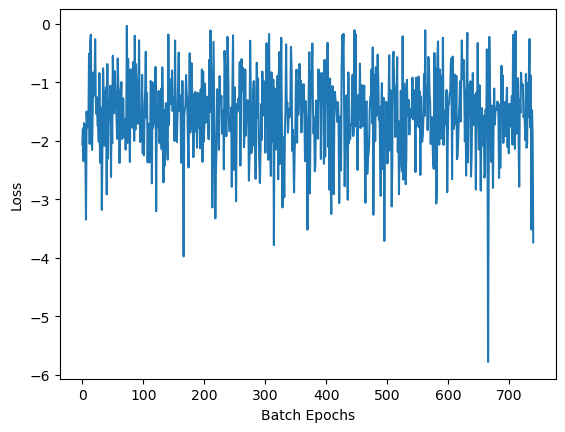

In [57]:
# plot the loss values
plt.plot(loss)
plt.xlabel('Batch Epochs')
plt.ylabel('Loss')
plt.show()

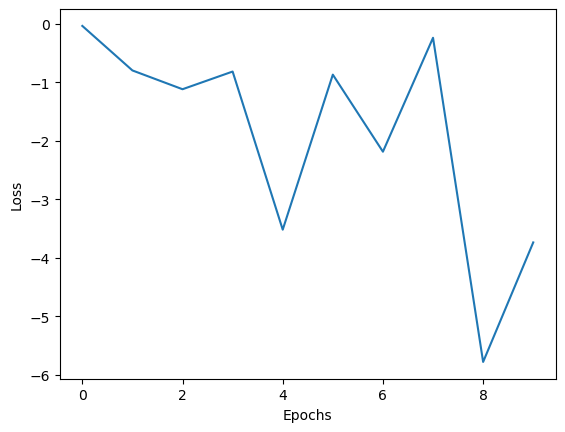

In [58]:
# plot the overall loss values
plt.plot(overall_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [60]:
# saving the model
torch.save(model.state_dict(), 'Baseline_model3/model.pt')
torch.save(optimizer.state_dict(), 'Baseline_model3/optimizer.pt')
torch.save(scheduler.state_dict(), 'Baseline_model3/scheduler.pt')